In [1]:
import jax.numpy as jnp
import jax
import jaxdem as jd
jax.config.update("jax_enable_x64", True)
import numpy as np
import os
from bump_utils import create_clumps
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from tqdm import tqdm

root = '/home/mmccraw/dev/data/26-01-01/grant/neighbor-list-characterization-3d/dynamics-1/rad-0.4-skin-0.01/'

traj_state = jd.utils.h5.load(os.path.join(root, 'state.h5'))
traj_system = jd.utils.h5.load(os.path.join(root, 'system.h5'))

pe = jax.vmap(jd.utils.thermal.compute_potential_energy)(traj_state, traj_system)
ke_t = jax.vmap(jd.utils.thermal.compute_translational_kinetic_energy)(traj_state)
ke_r = jax.vmap(jd.utils.thermal.compute_rotational_kinetic_energy)(traj_state)
te = pe + ke_r + ke_t

imbalances = []
for i in range(traj_state.shape[0]):
    f = traj_state.force[i]
    cid = traj_state.clump_ID[i]
    order = jnp.argsort(traj_state.unique_ID[i])
    _, offsets = jnp.unique(traj_state.clump_ID[i][order], return_index=True)
    imbalances.append(jnp.linalg.norm(jnp.sum(f[order][offsets], axis=0)))
imbalances = jnp.array(imbalances)

W0125 12:52:19.592284 1358440 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0125 12:52:19.594172 1358048 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [3]:
def force(i, j, pos, rad, bs, k):
    R = rad[i] + rad[j]
    rij = pos[i] - pos[j]
    rij -= bs * jnp.round(rij / bs)
    r = jnp.sum(rij**2, axis=-1)
    r = jnp.where(r == 0, 1.0, jnp.sqrt(r))
    s = R / r - 1.0
    s *= s > 0
    return (k * s)[..., None] * rij

def compute_forces(pos, rad, bs, nl, state, system):
    iota = jax.lax.iota(dtype=int, size=state.N)
    def per_particle_force(i, neighbors):
        def per_neighbor_force(j_id):
            valid = j_id != -1
            safe_j = jnp.maximum(j_id, 0)
            f = force(i, safe_j, pos, rad, bs, k=1)
            return f * valid
        forces = jax.vmap(per_neighbor_force)(neighbors)
        f_sum = jnp.sum(forces, axis=0)
        return f_sum
    return jax.vmap(per_particle_force)(iota, nl)

def draw(st, sy, j, ax=None, cell_alpha=0.2):
    if ax is None:
        ax = plt.gca()

    bs = sy.domain.box_size[j]
    pos = jnp.mod(st.pos[j], bs)
    rad = st.rad[j]
    nl = sy.collider.neighbor_list[j]
    f = compute_forces(
        pos,
        rad,
        bs,
        nl,
        st,
        sy,
    )

    cs = sy.collider.cell_list.cell_size[j]
    iteration = 0
    while True:
        if jnp.all(cs * iteration > bs):
            break
        ax.axvline(cs * iteration, c='k', alpha=cell_alpha, zorder=0)
        ax.axhline(cs * iteration, c='k', alpha=cell_alpha, zorder=0)
        iteration += 1

    ax.set_aspect('equal')
    ax.set_xlim(0, bs[0])
    ax.set_ylim(0, bs[1])
    for p, r in tqdm(zip(pos, rad), total=len(rad)):
        ax.add_patch(Circle(p, r))
    fp = f / jnp.linalg.norm(f, axis=-1, keepdims=True)
    ax.quiver(pos[:, 0], pos[:, 1], fp[:, 0], fp[:, 1])
    # ax.quiver(pos[:, 0], pos[:, 1], f[:, 0], f[:, 1])
    return f

def draw_neighbors(i, uuid, state, system, ax, scale=1.0, nc='r'):
    pos = state.pos[i]
    rad = state.rad[i]
    nl = system.collider.neighbor_list[i]
    ax.add_patch(Circle(pos[uuid], rad[uuid], facecolor='k'))
    for nuuid in nl[uuid]:
        if nuuid == -1:
            break
        ax.add_patch(Circle(pos[nuuid], rad[nuuid] * scale, facecolor=nc))

def check_missing_ids(pos, bs, clump_ID, nl_true, cutoff):
    dr = pos[:, None, :] - pos[None, ...]
    dr -= bs * jnp.round(dr / bs)
    r = jnp.linalg.norm(dr, axis=-1)
    id_i, id_j = jnp.triu_indices_from(r, k=1)
    clump_mask = clump_ID[id_i] != clump_ID[id_j]
    neighbor_mask = r[id_i, id_j][clump_mask] <= cutoff
    id_i = id_i[clump_mask][neighbor_mask]
    id_j = id_j[clump_mask][neighbor_mask]
    ids = jnp.column_stack((id_i, id_j))

    nl_ids = []
    for nl_id_i, nl_i in enumerate(nl_true):
        for nl_id_j in nl_i:
            if nl_id_i != -1 and nl_id_j != -1:
                nl_ids.append([nl_id_i, nl_id_j])
    nl_ids = jnp.array(nl_ids)

    missing_ids = []
    for ids in jnp.column_stack((id_i, id_j)):
        for test_ids in [ids, ids[::-1]]:
            if not jnp.any(jnp.all(nl_ids == test_ids, axis=-1)):
                print(f'Missing pairs {test_ids}')
                missing_ids.append(test_ids)
    return missing_ids

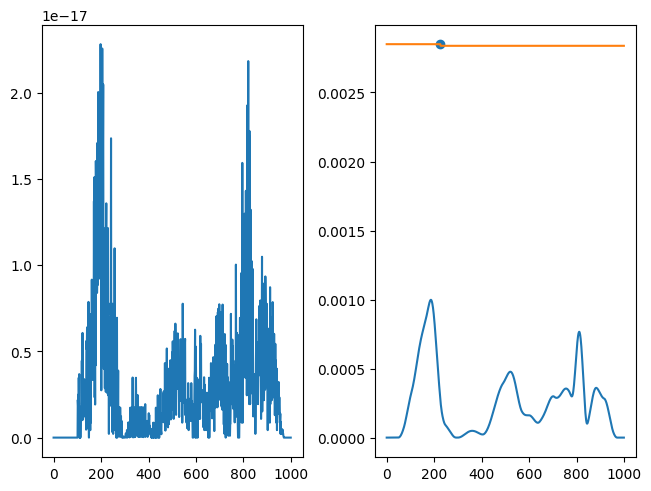

In [4]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].plot(imbalances)
ax[1].plot(pe)
ax[1].plot(te)
# ax[1].plot(np.diff(traj_system.collider.n_build_times) * np.max(te), zorder=0)
bad_indices = np.argwhere(np.abs(np.diff(te)) > 1e-6).flatten()
ax[1].scatter(bad_indices, te[bad_indices])

In [5]:
i = bad_indices[0] + 1
i_prev = i - 1
i_next = i + 1

# fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(10, 5))
# f_prev_prev = draw(traj_state, traj_system, i - 2, ax[0])
# f_prev = draw(traj_state, traj_system, i - 1, ax[1])
# f = draw(traj_state, traj_system, i, ax[2])
# f_next = draw(traj_state, traj_system, i + 1, ax[3])
# ax[2].set_title('First Bad Step')

# order = jnp.argsort(traj_state.unique_ID[i])
# order_prev = jnp.argsort(traj_state.unique_ID[i_prev])
# diff_ids = jnp.argwhere((jnp.linalg.norm(f[order], axis=-1) > 0) != (jnp.linalg.norm(f_prev[order_prev], axis=-1) > 0)).flatten()
# for uid in diff_ids:
#     uuid = int(jnp.argwhere(traj_state.unique_ID[i] == uid)[0][0])
#     uuid_prev = int(jnp.argwhere(traj_state.unique_ID[i_prev] == uid)[0][0])
#     draw_neighbors(i_prev, uuid_prev, traj_state, traj_system, ax[0], scale=0.5)
#     draw_neighbors(i, uuid, traj_state, traj_system, ax[1], scale=0.5)
# plt.savefig('example.png', dpi=600)

In [13]:
list_cutoff = float((traj_system.collider.cutoff + traj_system.collider.skin)[0])

nl_full = traj_system.collider.neighbor_list

# for i in bad_indices:
i = bad_indices[0]
k = i - 3
pos = traj_state.pos[k]
bs = traj_system.domain.box_size[k]
nl = nl_full[k]
clump_ID = traj_state.clump_ID[k]
unique_ID = traj_state.unique_ID[k]

missing_ids = check_missing_ids(pos, bs, clump_ID, nl, list_cutoff)

In [10]:
for missing_i, missing_j in missing_ids:
    dr = pos[missing_i] - pos[missing_j]
    dr -= bs * jnp.round(dr / bs)
    r = jnp.linalg.norm(dr, axis=-1)
    print(r, list_cutoff)

len(missing_ids)

0

In [11]:
cell_size = float(traj_system.collider.cell_list.cell_size[0])
min_grids_per_axis = 3

grid_dims = jnp.floor(bs / cell_size).astype(int)
# force to be at least 3 cells per axis
grid_dims = grid_dims.at[grid_dims < min_grids_per_axis].set(min_grids_per_axis)
# recompute cell size
cell_size = float(jnp.min(bs / grid_dims))

neighbor_mask = traj_system.collider.cell_list.neighbor_mask[0]
# get spatial partition
iota = jax.lax.iota(int, traj_state.N)
grid_dims = jnp.floor(bs / cell_size).astype(int)
grid_strides = jnp.concatenate([jnp.array([1], dtype=int), jnp.cumprod(grid_dims[:-1])])
# assign cell ids (my way)
cell_coords = jnp.floor(((pos / bs) % 1) * grid_dims).astype(int)
cell_ids = jnp.dot(cell_coords, grid_strides)

for ids in missing_ids:
    print(cell_ids[ids])

# sort (SKIPPED FOR NOW TO PRESERVE THE SAME ORDERING AS THE PREVIOUS NEIGHBOR LIST)
cell_ids, perm = jax.lax.sort([cell_ids, iota], num_keys=1)
cell_coords = cell_coords[perm]

# calculate neighboring cell ids
neighbor_cell_coords = cell_coords[:, None, :] + neighbor_mask
neighbor_cell_coords -= grid_dims * jnp.floor(neighbor_cell_coords / grid_dims).astype(int)  # apply pbc
neighbor_cell_ids = jnp.dot(neighbor_cell_coords, grid_strides)

_pos = pos[perm]
_clump_ID = clump_ID[perm]
_unique_ID = unique_ID[perm]

In [137]:
cid = jnp.argwhere(cell_ids == 24)[0][0]
neighbor_cell_ids[cid]

Array([14, 23,  5, 17, 26,  8, 11, 20,  2, 12, 21,  3, 15, 24,  6,  9, 18,
        0, 13, 22,  4, 16, 25,  7, 10, 19,  1], dtype=int64)

In [138]:
max_neighbors = 200
cutoff_sq = list_cutoff ** 2

def per_particle(idx, pos_i, stencil):
    cell_starts = jnp.searchsorted(cell_ids, stencil, side="left", method="scan_unrolled")
    # local_capacity = max_neighbors // 2 + 1
    def stencil_body(target_cell_hash, start_idx):
        init_carry = (
            start_idx,
            jnp.array(0, dtype=int),
            jnp.full((max_neighbors,), -1, dtype=int),
        )
        def cond_fun(val):
            k, c, _ = val
            in_cell = (k < traj_state.N) & (cell_ids[k] == target_cell_hash)
            has_space = c < max_neighbors
            return in_cell & has_space

        def body_fun(val):
            k, c, nl = val
            # dr = system_traj.domain.displacement(pos_i, pos[k], system)
            dr = pos_i - _pos[k]
            dr -= bs * jnp.round(dr / bs)
            d_sq = jnp.sum(dr**2, axis=-1)
            valid = (
                (_clump_ID[k] != _clump_ID[idx])
                * (d_sq <= cutoff_sq)
            )
            nl = jax.lax.cond(
                valid,
                lambda nl_: nl_.at[c].set(k),
                lambda nl_: nl_,
                nl,
            )
            c = c + valid.astype(c.dtype)
            return k + 1, c, nl
        _, local_c, local_nl = jax.lax.while_loop(cond_fun, body_fun, init_carry)
        return local_nl, local_c

    final_n_list, stencil_counts = jax.vmap(stencil_body)(stencil, cell_starts)
    row_offsets = jnp.cumsum(stencil_counts) - stencil_counts
    local_iota = jnp.arange(final_n_list.shape[1])
    target_indices = row_offsets[:, None] + local_iota[None, :]
    valid_mask = local_iota[None, :] < stencil_counts[:, None]
    safe_indices = jnp.where(valid_mask.flatten(), target_indices.flatten(), max_neighbors)
    result = jnp.full((max_neighbors,), -1, dtype=final_n_list.dtype)
    final_n_list = result.at[safe_indices].set(final_n_list.flatten(), mode="drop")
    return final_n_list, jnp.sum(stencil_counts) > max_neighbors

neighbor_list, overflows = jax.vmap(per_particle)(iota, _pos, neighbor_cell_ids)
jnp.any(overflows)


Array(False, dtype=bool)

In [139]:
missing_ids = check_missing_ids(_pos, bs, _clump_ID, neighbor_list, list_cutoff)